# Trying XGB Model

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import f1_score

from preprocess.preprocess_transaction_frequecy import preprocess_transaction_frequency
from preprocess.preprocess_init import preprocess_init
from preprocess.preprocess_time import preprocess_time
from preprocess.preprocess_change_card import preprocess_change_card
from preprocess.preprocess_mchno import preprocess_mchno
from preprocess.preprocess_special_features import preprocess_special_features
from preprocess.preprocess_conam import preprocess_conam
from preprocess.preprocess_train_test_split import preprocess_train_test_split

from util.generate_X_y import generate_X_y
from util.remove_outlier import remove_outlier
from util.generate_statistic import generate_statistic

from model.xgb_model import XGB_Model
from model.shap_importance import shap_importance
from model.plot import plot_importance

import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# Define features

These are the features i used in the model

In [2]:
raw_bool_features = ['ecfg',
                     'flbmk',
                     'flg_3dsmk',
                     'insfg',
                     'ovrlt'
                      ]

raw_categorial_features = ['contp',
                           'stscd',
                           'etymd',
                           'stocn',
                           'mcc',
                           'csmcu',
                           'hcefg',
                           'bacno',
                           'cano',
                           'mchno',
                           'acqic',
                           'scity'
                            ] 

raw_contiuous_feautres = ['loctm',
                          'conam',
                          'iterm'
                           ]

transaction_frequency_feautres = ['cano_days_txkey_count',
                                  'cano_locdt_txkey_count',
                                  'bacno_locdt_mchno_txkey_count'
                                    ]

time_feautres = ['last_time_days',
                 'next_time_days',
                 'cano_locdt_global_time_std' 
                    ]


change_card_feautres = ['diff_locdt_with_last_trans_cano',
                        'diff_locdt_of_two_card'
                           ]

conam_feautres = ['cano_locdt_conam_min',
                  'cano_locdt_conam_max',
                  'diff_gtime_with_conam_zero_trans_locdt'
                   ]

mchno_features = ['bacno_mchno_locdt_head_tail_diff',
                  'cano_days_mchno_index',    
                    ]


special_feautures = ['mchno_in_normal_mchno_list',
                    'mchno_in_fraud_mchno_list',
                    'conam_in_fraud_conam_list',
                    'diff_with_first_fraud_locdt'
                               ]

# XGB cannot handle categorical features
base_features =  (    raw_bool_features              
#                     + raw_categorial_features
                    + raw_contiuous_feautres
                    + transaction_frequency_feautres
                    + time_feautres
                    + change_card_feautres
                    + conam_feautres 
                    + mchno_features
                       )

label = 'fraud_ind'

# Preprocess

In [3]:
preprocess_group = False
if preprocess_group:
    df_train_raw = pd.read_csv('data/train.csv')
    df_test_raw = pd.read_csv('data/test.csv')
    df = preprocess_init(df_train_raw, df_test_raw, raw_bool_features)
    df = preprocess_transaction_frequency(df)
    df = preprocess_time(df)
    df = preprocess_change_card(df)
    df = preprocess_mchno(df)
    df = preprocess_conam(df)
    df = preprocess_special_features(df)
    df.to_pickle('data/df_preprocessed.pkl')
else:
    df = pd.read_pickle('data/df_preprocessed.pkl')    

# Base features

In [4]:
df_train, df_test = preprocess_train_test_split(df, raw_categorial_features)
input_features = base_features
X_train, y_train, groups, X_test = generate_X_y(df_train, df_test, label, input_features)
X_train.tail(10)

,ecfg,flbmk,flg_3dsmk,insfg,ovrlt,loctm,conam,iterm,cano_days_txkey_count,cano_locdt_txkey_count,bacno_locdt_mchno_txkey_count,last_time_days,next_time_days,cano_locdt_global_time_std,diff_locdt_with_last_trans_cano,diff_locdt_of_two_card,cano_locdt_conam_min,cano_locdt_conam_max,diff_gtime_with_conam_zero_trans_locdt,bacno_mchno_locdt_head_tail_diff,cano_days_mchno_index
1943429,0,0,0,0,0,202808.0,815.08,0,9,1,1,99046.0,NaN,NaN,0,NaN,815.08,815.08,NaN,0,1
1943430,1,0,0,0,0,61702.0,750.24,0,9,3,1,NaN,-46675.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943431,0,0,0,0,0,191457.0,841.64,0,9,3,1,46675.0,-7720.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943432,0,0,0,0,0,212337.0,381.65,0,9,3,1,7720.0,-84800.0,29430.624781,-13,NaN,381.65,841.64,NaN,0,1
1943433,0,0,0,0,0,205657.0,366.38,0,9,1,1,84800.0,-240959.0,NaN,-12,NaN,366.38,366.38,NaN,0,1
1943434,0,0,0,0,0,155256.0,1119.11,0,9,4,1,240959.0,-5347.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943435,0,0,0,0,0,172203.0,1334.91,0,9,4,3,5347.0,-2025.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,1
1943436,0,0,0,0,0,175548.0,1125.71,0,9,4,3,2025.0,-735.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,2
1943437,0,0,0,0,0,180803.0,1103.64,0,9,4,3,735.0,-749289.0,3661.951802,-9,NaN,1103.64,1334.91,NaN,0,3
1943438,1,0,0,1,0,101612.0,1194.66,1,9,1,1,749289.0,NaN,NaN,0,NaN,1194.66,1194.66,NaN,0,1


# Base Model

In [5]:
xgb = XGB_Model(input_features)
xgb.build_clf()
oof_preds_LGBM, df_sub_preds_LGBM, clf = xgb.run(X_train, y_train, groups, X_test, xgb.xgb_averge_precision, n_splits = 10)


Starting LightGBM. Fold 1,Train shape: (1521787, 21), test shape: (421665, 21)
Multiple eval metrics have been passed: 'validation_1-Averge_Precision' will be used for early stopping.

Will train until validation_1-Averge_Precision hasn't improved in 100 rounds.
[0]	validation_0-Averge_Precision:0.504314	validation_1-Averge_Precision:0.365261
[100]	validation_0-Averge_Precision:0.715663	validation_1-Averge_Precision:0.514745
[200]	validation_0-Averge_Precision:0.782394	validation_1-Averge_Precision:0.537452
[300]	validation_0-Averge_Precision:0.814641	validation_1-Averge_Precision:0.542225
[400]	validation_0-Averge_Precision:0.838157	validation_1-Averge_Precision:0.545036
[500]	validation_0-Averge_Precision:0.856285	validation_1-Averge_Precision:0.547258
[600]	validation_0-Averge_Precision:0.87059	validation_1-Averge_Precision:0.547188
Stopping. Best iteration:
[506]	validation_0-Averge_Precision:0.857196	validation_1-Averge_Precision:0.547611

Starting LightGBM. Fold 2,Train shape: (1

Starting LightGBM. Fold 10,Train shape: (1521787, 21), test shape: (421665, 21)
Multiple eval metrics have been passed: 'validation_1-Averge_Precision' will be used for early stopping.

Will train until validation_1-Averge_Precision hasn't improved in 100 rounds.
[0]	validation_0-Averge_Precision:0.481722	validation_1-Averge_Precision:0.447618
[100]	validation_0-Averge_Precision:0.700247	validation_1-Averge_Precision:0.607651
[200]	validation_0-Averge_Precision:0.765476	validation_1-Averge_Precision:0.626462
[300]	validation_0-Averge_Precision:0.799994	validation_1-Averge_Precision:0.62888
Stopping. Best iteration:
[282]	validation_0-Averge_Precision:0.794825	validation_1-Averge_Precision:0.629593

Summary:
XGB Testing_Set average_precision_score 0.633959


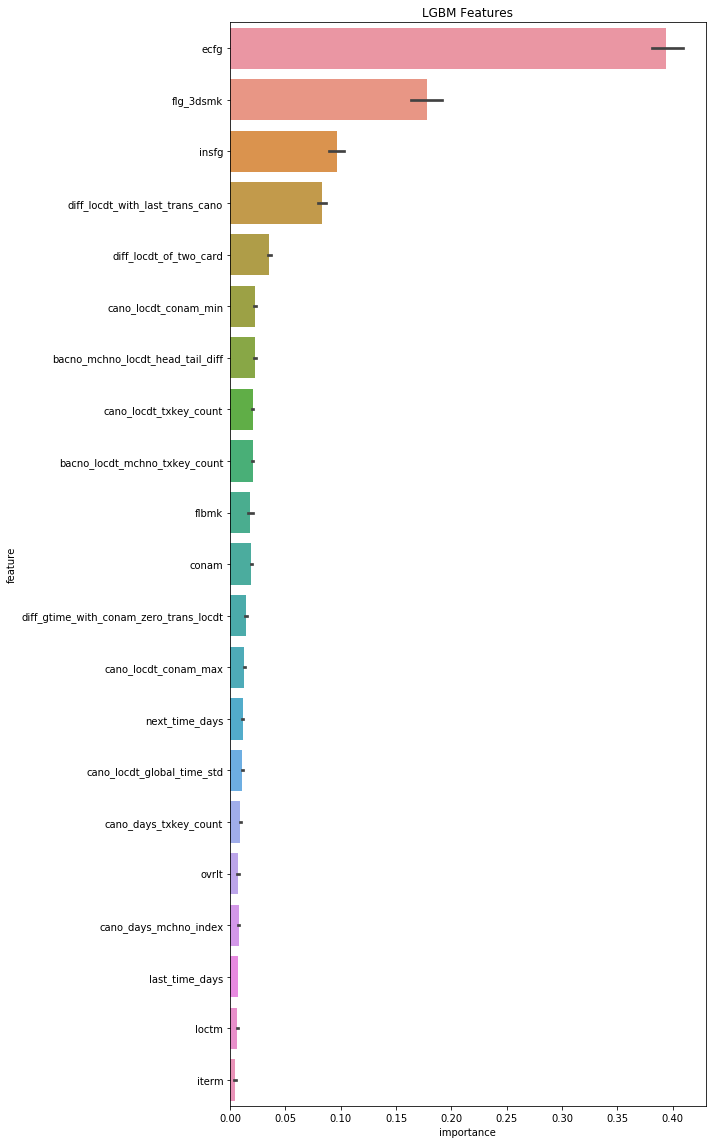

In [7]:
plot_importance(xgb.df_feature_importance)

In [ ]:
df_sub_preds_statistics = generate_statistic(df_sub_preds_LGBM)
df_sub_preds_statistics.head(10)

In [ ]:
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9].head(10)

# Remove Outier

Since some of the predictions above are very extreme, i drop it if the prediction is out of 1 standard deviation boundary.

In [ ]:
df_sub_preds_statistics['mean_remove_outlier'] = df_sub_preds_statistics.apply(remove_outlier, axis = 1)
df_sub_preds_statistics[df_sub_preds_statistics['max'] - df_sub_preds_statistics['min']>0.9][['mean','mean_remove_outlier']].head(10)

In [ ]:
df_train['oof_base_model'] = oof_preds_LGBM
df_test['sub_base_model'] = df_sub_preds_statistics['mean_remove_outlier']

## Find the range of threshold which maximizes the f1 score

In [ ]:
for i in range(0,70):
    print (i, f1_score(y_train, np.where(df_train['oof_base_model']>i/100,1,0) ))

## Create Submission

Use different models to predict based on different condiitons. Change the threshold to create submission. 

In [ ]:
threshold = 0.40

df_test['fraud_ind'] = np.where(df_sub_preds_LGBM.mean(axis = 1)> threshold, 1, 0)

df_test[['txkey','fraud_ind']].to_csv('result/sub_xgb_{}.csv'.format(threshold),index = False)